# CAGAYAN School Re-opening

- Simulation Start Date: September 15, 2021 
- Validation Data: September 16, 2021 - December 25, 2021 (100 days)
- Steps: 100
- Iterations: 20 

## 1. SEIRDV Data and Parameter Values

In [13]:
import matplotlib.pyplot as plt
import numpy as np 
import pandas as pd

### 1.1 Population of CAGAYAN

CAGAYAN 2015 Population
- Source: https://psa.gov.ph/content/philippine-population-surpassed-100-million-mark-results-2015-census-population
- Accessed: January 15, 2021

In [14]:
cagayan_pop_2015 = [
    69746 + 292963, # 0 - 4
    358204, # 5 - 9
    337967, # 10 - 14
    332294, # 15 - 19
    318664, # 20 - 24
    279492, # 25 - 29
    247474, # 30 - 34
    233394,  # 35 - 39
    205056,  # 40 - 44
    205056,  # 45 - 49
    166434,  # 50 - 54
    138279,  # 55 - 59
    104998,  # 60 - 64
    69552,  # 65 - 69
    43042,  # 70 - 74
    33989,   # 75 - 79
    32097,   # 80 years and over
]

# Population Distribution in 2015
cagayan_pop_2015_dist = np.divide(cagayan_pop_2015, sum(cagayan_pop_2015))

We use the population distribution of CAGAYAN in 2015 to estimate the distribution in 2020. 

CAGAYAN 2020 Population 
- Source: https://psa.gov.ph/content/2020-census-population-and-housing-2020-cph-population-counts-declared-official-president
- Accessed: December 11, 2021

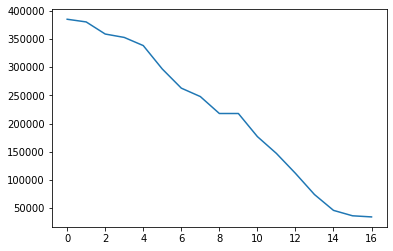

In [15]:
cagayan_pop_2020 = 3685744
cagayan_pop_2020 = cagayan_pop_2020 * cagayan_pop_2015_dist
plt.plot(cagayan_pop_2020)

### 1.2 DOH Data: Active, Dead, Recovered 

The COVID-19 data from the DOH Data Drop is divided into three batches, i.e., 0, 1, and 2. We will combine the number of active, dead, and recovered individuals from 2020 to August 1, 2021.

In [16]:
import utils.covid_data_extractor as covid_extractor

region = "Region II: Cagayan Valley"
batches = 4
age_groups = 17
active = np.zeros(age_groups)
deaths = np.zeros(age_groups)
recoveries = np.zeros(age_groups)

for i in range(batches):
    # Opens the file and instantiates the extractor
    filename = "input/covid_data/DOH COVID Data Drop_ 20220305 - 04 Case Information_batch_%i.csv" % (i)
    extractor = covid_extractor.DOHCovid19DataExtractor(filename)
    
    # Sets start and end dates to filter records that are gathered within the dates (inclusive)
    start = {"m": 1, "d": 1, "y": 2020}
    end = {"m": 1, "d": 17, "y": 2022}
    extractor.cut_data(start, end, 'DateResultRelease')
    
    # Extracts the cases in the region
    cases = extractor.count_cases("RegionRes", region)
    active = active + cases["I"]
    deaths = deaths + cases["D"]
    recoveries = recoveries + cases["R"]
    
pd.DataFrame([active, deaths, recoveries], index=["active", "dead", "recovered"]).transpose()

<ipython-input-16-4a35c395192d>:13: DtypeWarning: Columns (15,16) have mixed types.Specify dtype option on import or set low_memory=False.
  extractor = covid_extractor.DOHCovid19DataExtractor(filename)


,active,dead,recovered
0,7.0,66.0,5080.0
1,1.0,12.0,4954.0
2,7.0,14.0,6565.0
3,10.0,15.0,8400.0
4,57.0,36.0,12443.0
5,147.0,62.0,14061.0
6,131.0,94.0,12813.0
7,77.0,143.0,10009.0
8,53.0,187.0,9626.0
9,54.0,277.0,8664.0


### 1.4 Vaccine Efficacy Estimate

We estimate the average efficacy by getting the weighted average of efficacy (lower bound) of the vaccines and the supply available in the Philippines.

Data:
- Supply in PH as of Oct 10, 2021

In [17]:
sinovac = 41500000
astrazeneca = 11103340
pfizer = 23328630
sputnik_v = 1290000
johnson_and_johnson = 3240850
moderna = 9985800
sinopharm = 1100000
supply = [sinovac, astrazeneca, pfizer, sputnik_v, johnson_and_johnson, moderna, sinopharm]
efficacy = [0.650, 0.704, 0.950, 0.916, 0.669, 0.941, 0.790] # lower bound

# Weighted Average
expected_efficacy = sum(np.multiply(supply, efficacy)) / sum(supply) 
expected_efficacy

0.7708401973727185

### 1.6 SEIRDV

- n = cagayan's 2020 Population
- e = exposed = 0 (assumption) 
- i = infectious = active 
- r = recovered
- d = dead 
- v = vaccinated
- s = n - (e + i + r + d + v)

In [18]:
n = cagayan_pop_2020
e = 0 # assumption 
i = active 
r = recoveries 
d = deaths
s = n - (e + i + r + d)

Vaccination Scenarios: 7.4%, 25%, 50%, 75%, 100%

In [19]:
# Eligible population: Ages 16 and above only 
eligible = np.concatenate(([0, 0, 0], s[3:]))

# Vaccinated Individuals
v_control = eligible * expected_efficacy * 0
v_25 = eligible * expected_efficacy * 0.25
v_50 = eligible * expected_efficacy * 0.5
v_75 = eligible * expected_efficacy * 0.75
v_100 =  eligible * expected_efficacy * 1
v_scenarios = [v_control, v_25, v_50, v_75, v_100]

# SEIRDV Data for each scenario
seirdv_control = {}
seirdv_25 = {}
seirdv_50 = {}
seirdv_75 = {}
seirdv_100 = {}
seirdv_data = [seirdv_control, seirdv_25, seirdv_50, seirdv_75, seirdv_100]

for j, seirdv in enumerate(seirdv_data):
    seirdv["S"] = s - v_scenarios[j]
    seirdv["E"] = e
    seirdv["I"] = i
    seirdv["R"] = r
    seirdv["D"] = d
    seirdv["V"] = v_scenarios[j]

print("Control Scenario")
pd.DataFrame(seirdv_control)

Control Scenario


,S,E,I,R,D,V
0,380251.369098,0,7.0,5080.0,66.0,0.0
1,375650.482964,0,1.0,4954.0,12.0,0.0
2,352528.216662,0,7.0,6565.0,14.0,0.0
3,344661.246620,0,10.0,8400.0,15.0,0.0
4,326067.392456,0,57.0,12443.0,36.0,0.0
5,282710.328385,0,147.0,14061.0,62.0,0.0
6,249920.903248,0,131.0,12813.0,94.0,0.0
7,237768.891757,0,77.0,10009.0,143.0,0.0
8,208020.730988,0,53.0,9626.0,187.0,0.0
9,208891.730988,0,54.0,8664.0,277.0,0.0


### 1.7 Rescaled SEIRDV

We rescale each of our SEIRDV data to reduce the memory requirement of our simulations. Our target population is 25000 agents. The real agent population will vary because of rounding offsets. 

In [20]:
target_agent_pop = sum(cagayan_pop_2020 // 257)
target_agent_pop

14332.0

In [21]:
for i, seirdv in enumerate(seirdv_data):
    seirdv_data[i] = pd.DataFrame(seirdv_data[i]) / sum(n) # Distribution
    seirdv_data[i] = seirdv_data[i] * target_agent_pop # Rescale
    seirdv_data[i] = seirdv_data[i].apply(np.ceil) # Ceiling of values
    seirdv_data[i] = dict([(state, [int(i) for i in list(seirdv_data[i][state].values)]) for state in "SEIRDV"])

seirdv_control, seirdv_25, seirdv_50, seirdv_75, seirdv_100 = seirdv_data
print("Control Scenario")
pd.DataFrame(seirdv_control)

Control Scenario


,S,E,I,R,D,V
0,1479,0,1,20,1,0
1,1461,0,1,20,1,0
2,1371,0,1,26,1,0
3,1341,0,1,33,1,0
4,1268,0,1,49,1,0
5,1100,0,1,55,1,0
6,972,0,1,50,1,0
7,925,0,1,39,1,0
8,809,0,1,38,1,0
9,813,0,1,34,2,0


### 1.8 Parameter Values

- infection rate
- death rate
- recovery rate

In [28]:
# data from NCR notebook

infection_rate = [0.024233,0.027834,0.033804,0.045498,0.108900,0.152223,0.127870,0.097103,0.080300,0.064615,0.060388,0.052108,0.041990,0.031190,0.022596,0.012703,0.016647]
death_rate = [0.000104,0.000019,0.000037,0.000066,0.000122,0.000236,0.000286,0.000384,0.000561,0.000680,0.001038,0.001306,0.001690,0.001829,0.001790,0.001263,0.002028]
recovery_rate = [0.024126,0.027813,0.033765,0.045431,0.108783,0.151995,0.127589,0.096722,0.079741,0.063935,0.059350,0.050801,0.040299,0.029358,0.020803,0.011436,0.014615]

pd.DataFrame([infection_rate, death_rate, recovery_rate], index=["infection_rate", "death_rate", "recovery_rate"])

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
infection_rate,0.024233,0.027834,0.033804,0.045498,0.108900,0.152223,0.127870,0.097103,0.080300,0.064615,0.060388,0.052108,0.041990,0.031190,0.022596,0.012703,0.016647
death_rate,0.000104,0.000019,0.000037,0.000066,0.000122,0.000236,0.000286,0.000384,0.000561,0.000680,0.001038,0.001306,0.001690,0.001829,0.001790,0.001263,0.002028
recovery_rate,0.024126,0.027813,0.033765,0.045431,0.108783,0.151995,0.127589,0.096722,0.079741,0.063935,0.059350,0.050801,0.040299,0.029358,0.020803,0.011436,0.014615


## 2. Contact Matrices 

In [29]:
import utils.utils

### 2.1 No School Re-opening

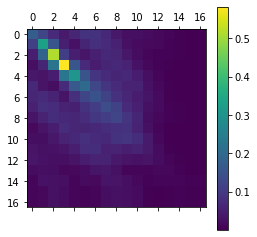

In [30]:
cm0 = utils.utils.parse_json("input/contact_matrices/cm_0.json") # No opening
plt.matshow(cm0)
plt.colorbar()

### 2.2 100% School Re-opening

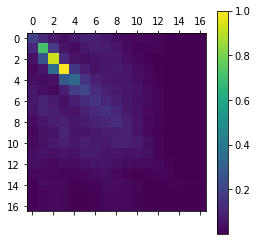

In [31]:
cm100 = utils.utils.parse_json("input/contact_matrices/cm_100.json")
plt.matshow(cm100)
plt.colorbar()

## 3. Simulations

In [32]:
from batchrunner import batchrun

iterations = 20
steps = 300

### 3.1 Vaccination Scenarios under No School Reopening Scenario

In [33]:
fixed_params = utils.utils.parse_json("input/fixed_params.json")
fixed_params["infection_rate"] = infection_rate
fixed_params["death_rate"] = death_rate
fixed_params["recovery_rate"] = recovery_rate

scenarios = {
    "sim0": seirdv_control, 
    "sim1": seirdv_25, 
    "sim2": seirdv_50, 
    "sim3": seirdv_75, 
    "sim4": seirdv_100
}

for sim_id in scenarios:
    print(sim_id)
    batchrun(iterations, steps, sim_id, scenarios[sim_id], fixed_params, cm0, "output/CAGAYAN/output_0")

sim0
running...
Batch run finished.
sim1
running...
Batch run finished.
sim2
running...
Batch run finished.
sim3
running...
Batch run finished.
sim4
running...
Batch run finished.


### 3.2 Vaccination Scenarios under 100% School Reopening Scenario

In [34]:
for sim_id in scenarios:
        print(sim_id)
        batchrun(iterations, steps, sim_id, scenarios[sim_id], fixed_params, cm100, "output/CAGAYAN/output_100")

sim0
running...
Batch run finished.
sim1
running...
Batch run finished.
sim2
running...
Batch run finished.
sim3
running...
Batch run finished.
sim4
running...
Batch run finished.


## 4. Analysis

In [35]:
import utils.analysis

total_population = sum(pd.DataFrame(pd.DataFrame(i).sum() for i in seirdv_data).sum()) / len(seirdv_data)
scale = 10000
sim_ids = {
    "sim0": "0% Vaccination",
    "sim1": "25% Vaccination",
    "sim2": "50% Vaccination",
    "sim3": "75% Vaccination",
    "sim4": "100% Vaccination"
}
colors = {
    "sim0": "k", 
    "sim1": "C1", 
    "sim2": "C2", 
    "sim3": "C3", 
    "sim4": "C4"
}
styles = {
    "sim0": ":", 
    "sim1": "-", 
    "sim2": "-", 
    "sim3": "-", 
    "sim4": "-"
}
states = "SEIRDV"

### 4.1 No School Re-opening

#### 4.1.1 Age Dynamics

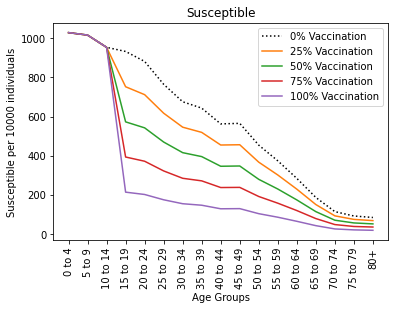

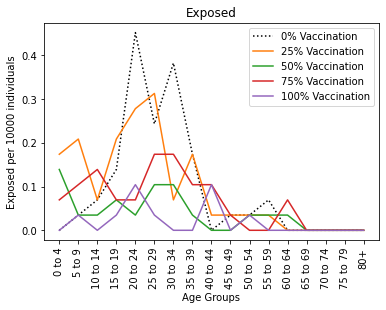

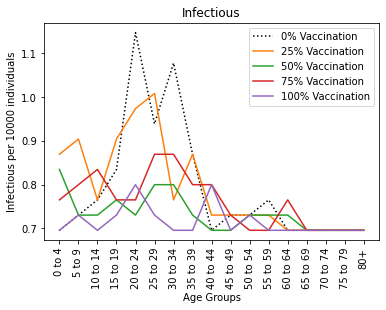

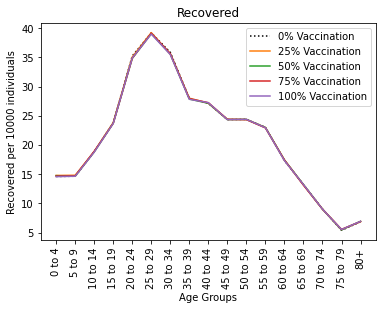

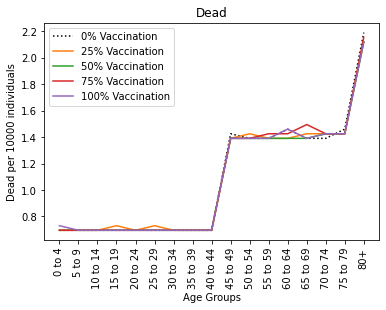

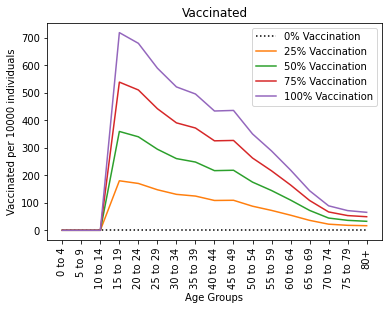

In [36]:
utils.analysis.plot_average_age_dist(
    sim_ids, 
    states, 
    iterations, 
    total_population, 
    scale, colors, 
    styles, 
    "output/CAGAYAN/output_0"
)

#### 4.1.2 Temporal Dynamics

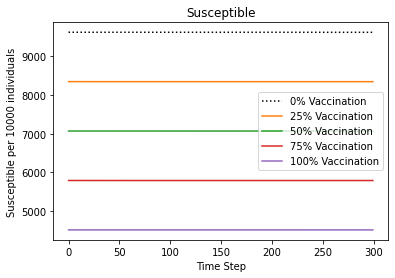

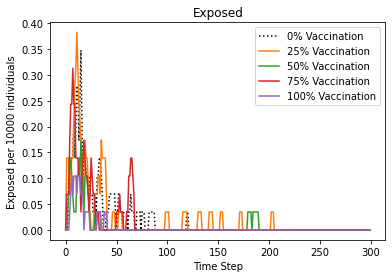

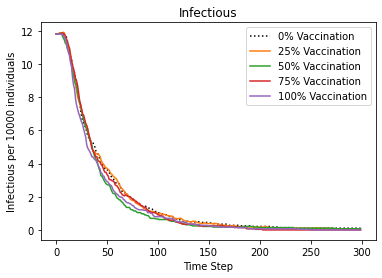

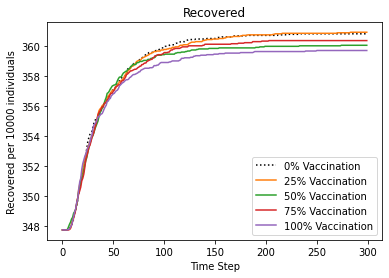

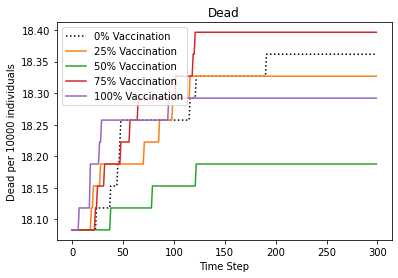

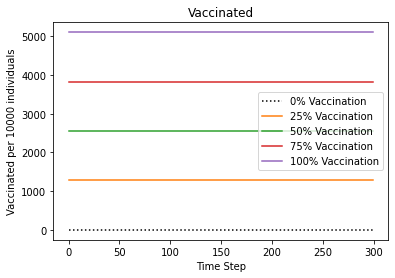

In [37]:
utils.analysis.plot_average_time_series(
    sim_ids, 
    states, 
    steps, 
    iterations, 
    total_population, 
    scale, 
    colors, 
    styles, 
    "output/CAGAYAN/output_0"
)

### 4.2 100% School Re-opening

#### 4.2.1 Age Dynamics

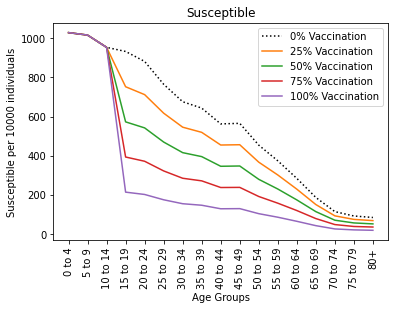

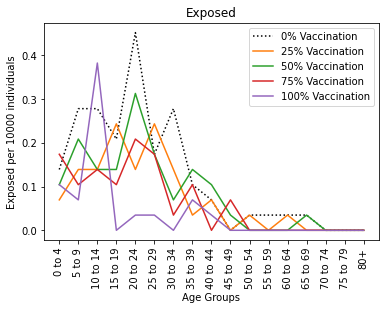

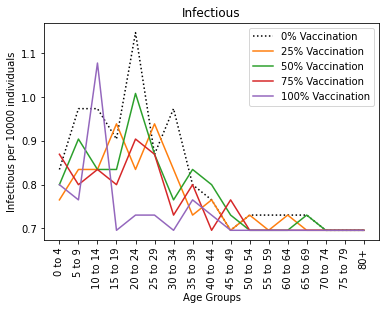

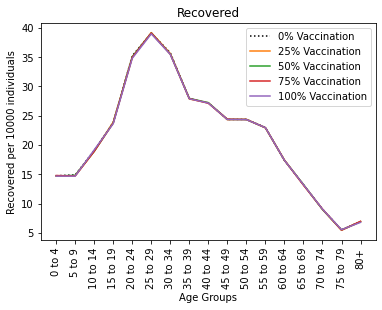

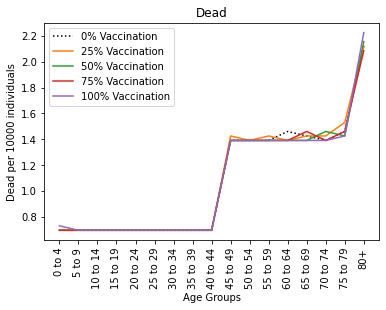

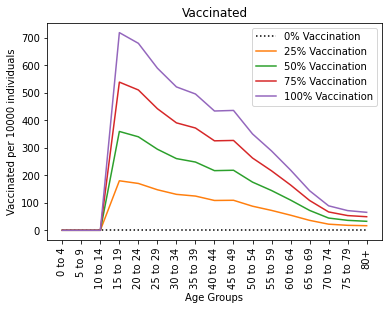

In [38]:
utils.analysis.plot_average_age_dist(
    sim_ids, 
    states, 
    iterations, 
    total_population, 
    scale, colors, 
    styles, 
    "output/CAGAYAN/output_100"
)

#### 4.2.2 Temporal Dynamics

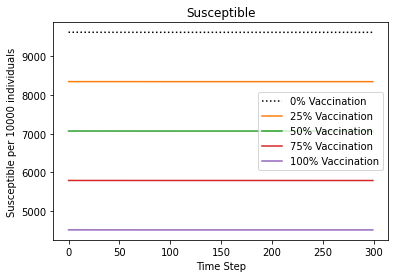

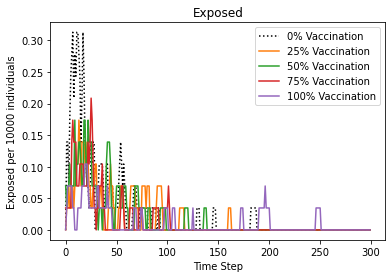

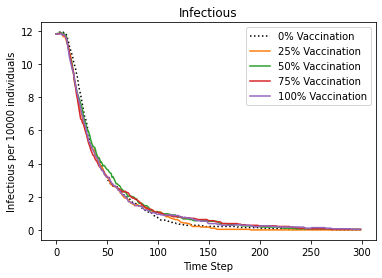

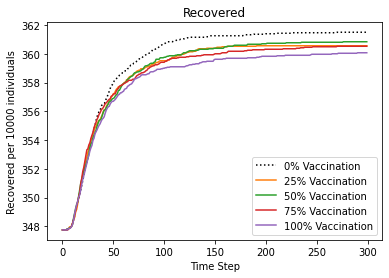

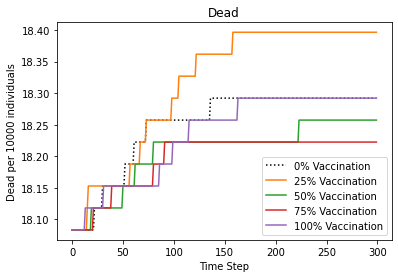

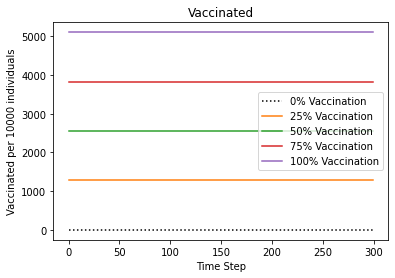

In [39]:
utils.analysis.plot_average_time_series(
    sim_ids, 
    states, 
    steps, 
    iterations, 
    total_population, 
    scale, 
    colors, 
    styles, 
    "output/CAGAYAN/output_100"
)

### 4.3 Summary

In [40]:
summary_0 = pd.DataFrame([])
summary_100 = pd.DataFrame([])

for sim_id in sim_ids:
    summary_0[sim_id] = pd.DataFrame(
        utils.analysis.get_average_age_dist(
            sim_id, 
            iterations, 
            states, 
            "output/CAGAYAN/output_0"), 
        index=['S', "E", "I", "R", "D", "V"]).sum(axis=1)
    summary_100[sim_id] = pd.DataFrame(
        utils.analysis.get_average_age_dist(
            sim_id, 
            iterations, 
            states, 
            "output/CAGAYAN/output_100"), 
        index=['S', "E", "I", "R", "D", "V"]).sum(axis=1)
    
summary_0 = summary_0
summary_100 = summary_100

#### 4.3.1 Summary

In [41]:
summary_0

,sim0,sim1,sim2,sim3,sim4
S,13825.65,11994.65,10163.05,8328.40,6496.5
E,2.35,2.35,0.95,1.60,0.5
I,19.35,19.35,17.95,18.60,17.5
R,518.80,518.95,517.70,518.15,517.2
D,26.40,26.35,26.15,26.45,26.3
V,0.00,1839.00,3673.00,5506.00,7340.0


In [42]:
summary_100

,sim0,sim1,sim2,sim3,sim4
S,13824.95,11995.15,10161.90,8328.40,6495.95
E,3.05,1.85,2.10,1.60,1.05
I,20.05,18.85,19.10,18.60,18.05
R,519.75,518.40,518.80,518.35,517.70
D,26.30,26.45,26.25,26.20,26.30
V,0.00,1839.00,3673.00,5506.00,7340.00


In [43]:
control_scenario = summary_0 * 0 
control_scenario["sim0"] = summary_0["sim0"]
control_scenario

,sim0,sim1,sim2,sim3,sim4
S,13825.65,0.0,0.0,0.0,0.0
E,2.35,0.0,0.0,0.0,0.0
I,19.35,0.0,0.0,0.0,0.0
R,518.80,0.0,0.0,0.0,0.0
D,26.40,0.0,0.0,0.0,0.0
V,0.00,0.0,0.0,0.0,0.0


#### 4.3.2 Change in Infections and Deaths

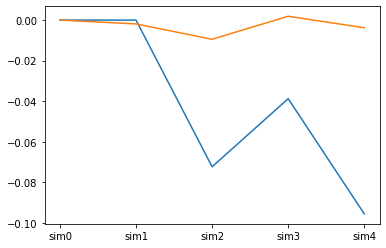

In [44]:
change_0 = ((summary_0.transpose() - summary_0["sim0"]) / summary_0["sim0"]).transpose()
infection_change_0 = change_0.transpose()["I"]
death_change_0 = change_0.transpose()["D"]

plt.plot(infection_change_0)
plt.plot(death_change_0)

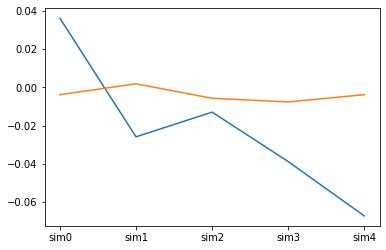

In [45]:
change_100 = ((summary_100.transpose() - summary_0["sim0"]) / summary_0["sim0"]).transpose()
infection_change_100 = change_100.transpose()["I"]
death_change_100 = change_100.transpose()["D"]

plt.plot(infection_change_100)
plt.plot(death_change_100)

In [46]:
infection_change_100

sim0    0.036176
sim1   -0.025840
sim2   -0.012920
sim3   -0.038760
sim4   -0.067183
Name: I, dtype: float64

In [47]:
death_change_100

sim0   -0.003788
sim1    0.001894
sim2   -0.005682
sim3   -0.007576
sim4   -0.003788
Name: D, dtype: float64

In [48]:
v = [0, 25, 50, 75, 100]

death_downtick = 0
infection_downtick = 0

for i in range(5):
    if death_change_100[0] < 0 or death_change_100[4] > 0 :
        break
    
    if death_change_100[i] < 0:
        x = [v[i - 1], v[i]]
        y = [death_change_100[i - 1], death_change_100[i]]

        coefficients = np.polyfit(x, y, 1)
        
        death_downtick = abs(coefficients[1] / coefficients[0])
        break

for i in range(5):
    if infection_change_100[0] < 0 or infection_change_100[4] > 0:
        break
    
    if infection_change_100[i] < 0:
        x = [v[i - 1], v[i]]
        y = [infection_change_100[i - 1], infection_change_100[i]]

        coefficients = np.polyfit(x, y, 1)

        infection_downtick = abs(coefficients[1] / coefficients[0])
        break

output = "Death Downtick: {d}%\n Infection Downtick: {i}%".format(d = death_downtick, i = infection_downtick)
output

'Death Downtick: 0%\n Infection Downtick: 14.583333333333325%'

#### 4.3.3 Combined Graphs

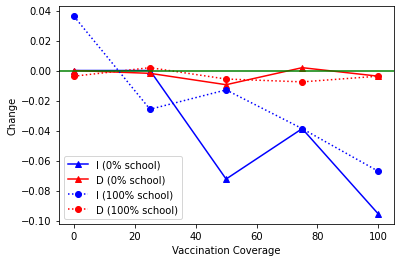

In [49]:
plt.xlabel("Vaccination Coverage")
plt.ylabel("Change")
plt.plot(v, infection_change_0, "b-^")
plt.plot(v, death_change_0, "r-^")
plt.plot(v, infection_change_100, "b:o")
plt.plot(v, death_change_100, "r:o")
plt.axhline(y=0, color='g', linestyle='-')
plt.legend(["I (0% school)", "D (0% school)", "I (100% school)", "D (100% school)"])